# SEC Filings' Sentiment and Similiarity Metrics Project

In [1]:
import re
import glob
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing as mp
import matplotlib.pyplot as plt
from ast import literal_eval
from tqdm.notebook import tqdm
from finpie import historical_prices
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# set plot styles
plt.style.use('seaborn')
plt.rcParams['text.color'] = 'black'
plt.rcParams[ "figure.figsize"] = (20, 10)

# load custom classes
from classes.sec_class import SecData
from classes.wordcloud_class import wordCloud
from classes.text_processing_class import textPreProcess

sec = SecData()
wc = wordCloud()
tpp = textPreProcess()

## Collected Data

- Management discussion and analysis section of 10-K and 10-Q filings from SEC Edgars database collected with regular expressions, so far for the 30 companies in the DOW Jones Index

In [2]:
df = pd.read_csv('10q10k.csv', index_col = 0)
df.mdna = df.mdna.astype(str)
display(df.head(10))
print('Total number of reports:', len(df))
print('Total number of companies', len(np.unique(df.ticker)))

,mdna,type,ticker,cik,sic
2020-10-27,Item 2. Management’s Discussion and Analysis ...,10-Q,mmm,66740,3841
2020-07-28,Item 2. Management’s Discussion and Analysis ...,10-Q,mmm,66740,3841
2020-04-28,Item 2. Management’s Discussion and Analysis ...,10-Q,mmm,66740,3841
2019-10-25,Item 2. Management’s Discussion and Analysis ...,10-Q,mmm,66740,3841
2019-07-26,Item 2. Management’s Discussion and Analysis ...,10-Q,mmm,66740,3841
2019-04-26,Item 2. Management’s Discussion and Analysis ...,10-Q,mmm,66740,3841
2018-10-25,Item 2. Management’s Discussion and Analysis ...,10-Q,mmm,66740,3841
2018-07-26,Item 2. Management’s Discussion and Analysis ...,10-Q,mmm,66740,3841
2018-05-08,Item 2. Management’s Discussion and Analysis ...,10-Q,mmm,66740,3841
2017-10-31,Item 2. Management’s Discussion and Analysis ...,10-Q,mmm,66740,3841


Total number of reports: 1959
Total number of companies 30


## Calculated sentiment

- The sentiment was calculated using a lexica based method using the Loughran-McDonald dictionary for now

In [10]:
sentiment_columns = [ 'Negative','Positive', 'Uncertainty', 'Litigious', 'Constraining', 'Superfluous', 'Interesting' ]
df = pd.read_csv('sentiment.csv', index_col = 0)
display(df.head())

,mdna,type,ticker,cik,sic,lemmatised_text,Negative,Positive,Uncertainty,Litigious,Constraining,Superfluous,Interesting,text
1994-02-14,ITEM 2. Management's Discussion and Analysis ...,10-Q,msft,789019,7372,"['item', 'management', 'discussion', 'analysis...",5.0,3.0,4.0,4.0,0.0,0.0,1.0,item management discussion analysis financial ...
1994-03-07,Item 7. Management's Discussion and Analys...,10-K,mmm,66740,3841,"['item', 'management', 'discussion', 'analysis...",23.0,14.0,7.0,13.0,6.0,0.0,2.0,item management discussion analysis financial ...
1994-03-17,Item 7. Management's Discussion and Analysis o...,10-K,ba,12927,3721,"['item', 'management', 'discussion', 'analysis...",0.0,0.0,0.0,0.0,1.0,0.0,0.0,item management discussion analysis financial ...
1994-03-28,ITEM 7. MANAGEMENT'S DISCUSSION AND ANALYSIS O...,10-K,ibm,51143,3570,"['item', 'management', 'discussion', 'analysis...",0.0,1.0,2.0,1.0,2.0,0.0,0.0,item management discussion analysis financial ...
1994-03-29,Item 7. Management's Discussion and Analysis...,10-K,mcd,63908,5812,"['item', 'management', 'discussion', 'analysis...",22.0,31.0,6.0,7.0,4.0,0.0,2.0,item management discussion analysis financial ...


### Sentiment time-series example for Apple


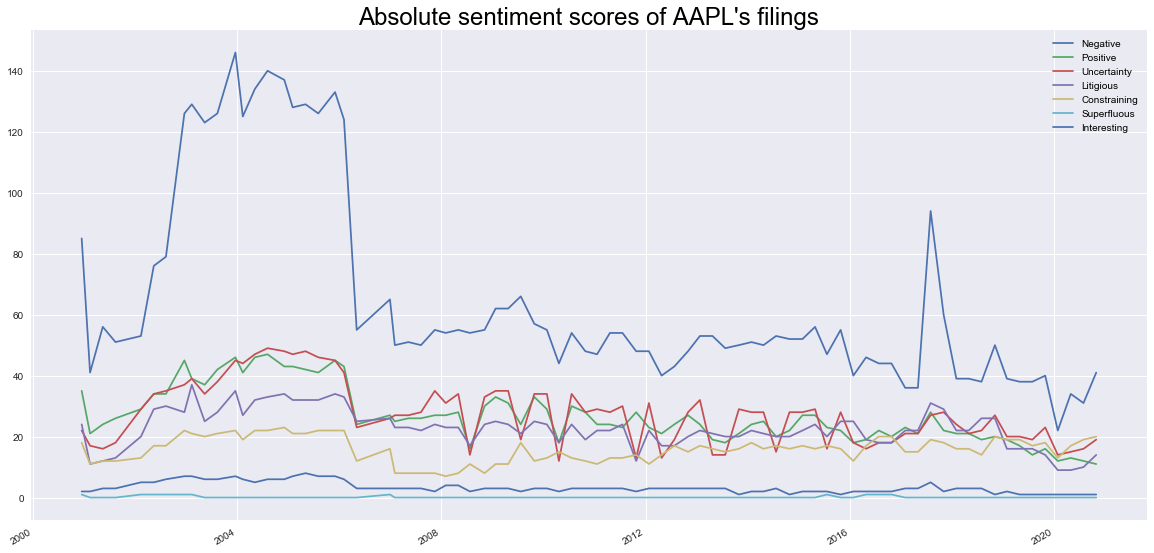

In [85]:
ticker = 'aapl'
ticker_df = df[df.ticker == ticker]['2000-01-01':].copy()
ticker_df.index = pd.to_datetime(ticker_df.index)
ticker_df.sort_index(inplace = True)
ticker_df[sentiment_columns].plot()
plt.title(f'Absolute sentiment scores of {ticker.upper()}\'s filings', fontsize = 24)
plt.show()

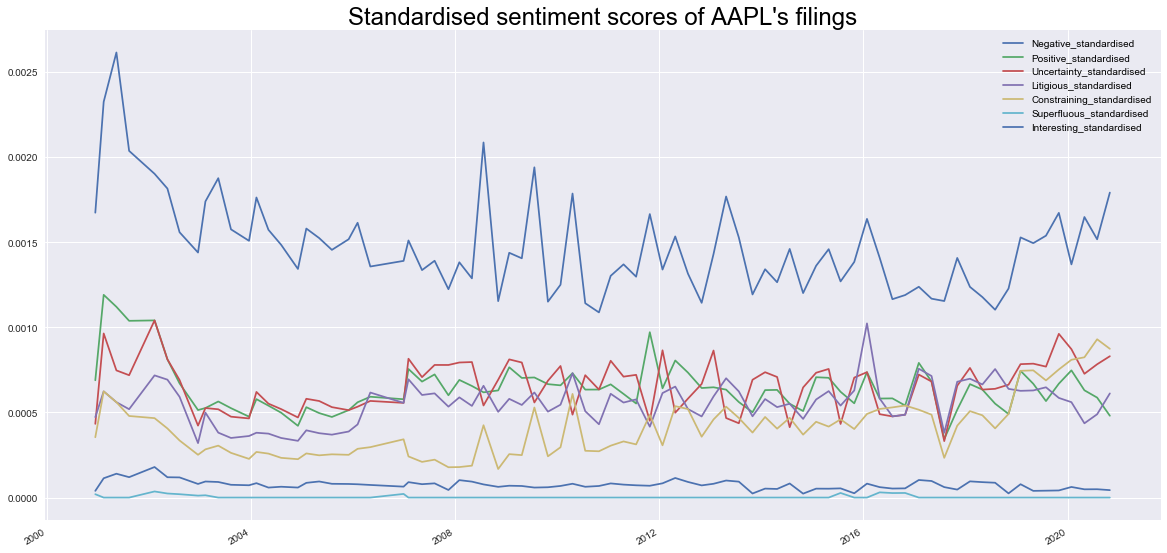

In [86]:
# rescale sentiment based on doc length -> "average sentiments"
df['doc_length'] = [ len(d) for d in df.lemmatised_text ]
for col in sentiment_columns:
    df[col + '_standardised' ] = df[col] / df['doc_length']
standardised_sentiment_columns = [ col + '_standardised' for col in sentiment_columns ]
ticker_df = df[df.ticker == ticker]['2000-01-01':].copy()
ticker_df.index = pd.to_datetime(ticker_df.index)
ticker_df.sort_index(inplace = True)
ticker_df[standardised_sentiment_columns].plot()
plt.title(f'Standardised sentiment scores of {ticker.upper()}\'s filings', fontsize = 24)
plt.show()

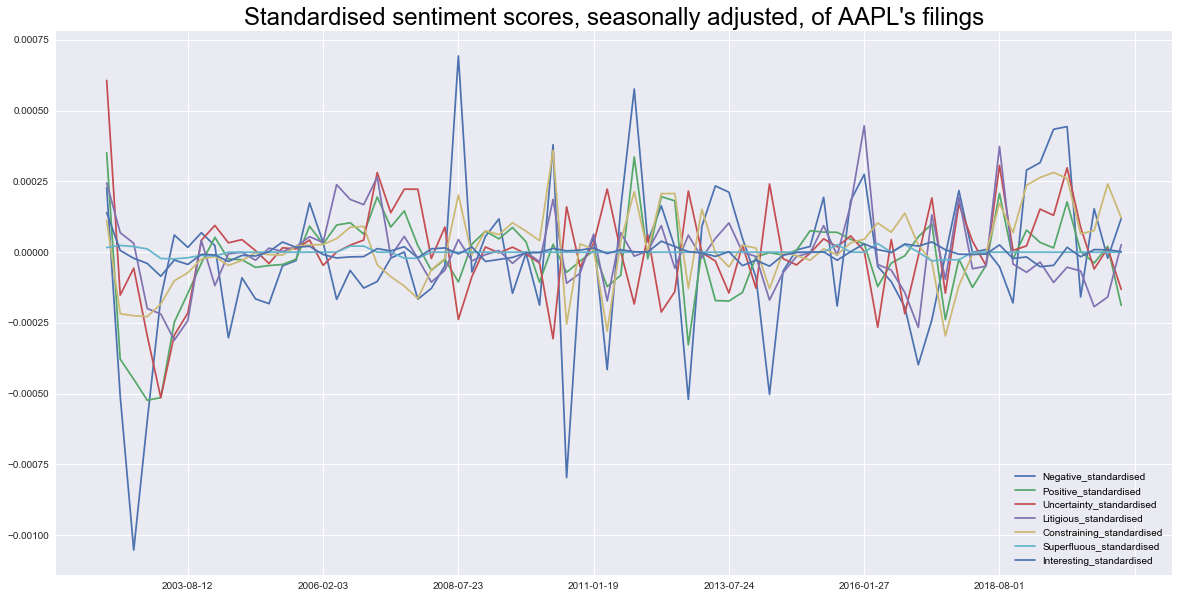

In [89]:
trial_df = df[ ['ticker'] + standardised_sentiment_columns]['2000-01-01':].copy()
trial_df = trial_df[trial_df.ticker == ticker]
trial_df[standardised_sentiment_columns] += 1
trial_df[standardised_sentiment_columns] = trial_df[standardised_sentiment_columns] / trial_df[standardised_sentiment_columns].shift(4) - 1
trial_df.plot()
plt.title(f'Standardised sentiment scores, seasonally adjusted, of {ticker.upper()}\'s filings', fontsize = 24)
plt.show()

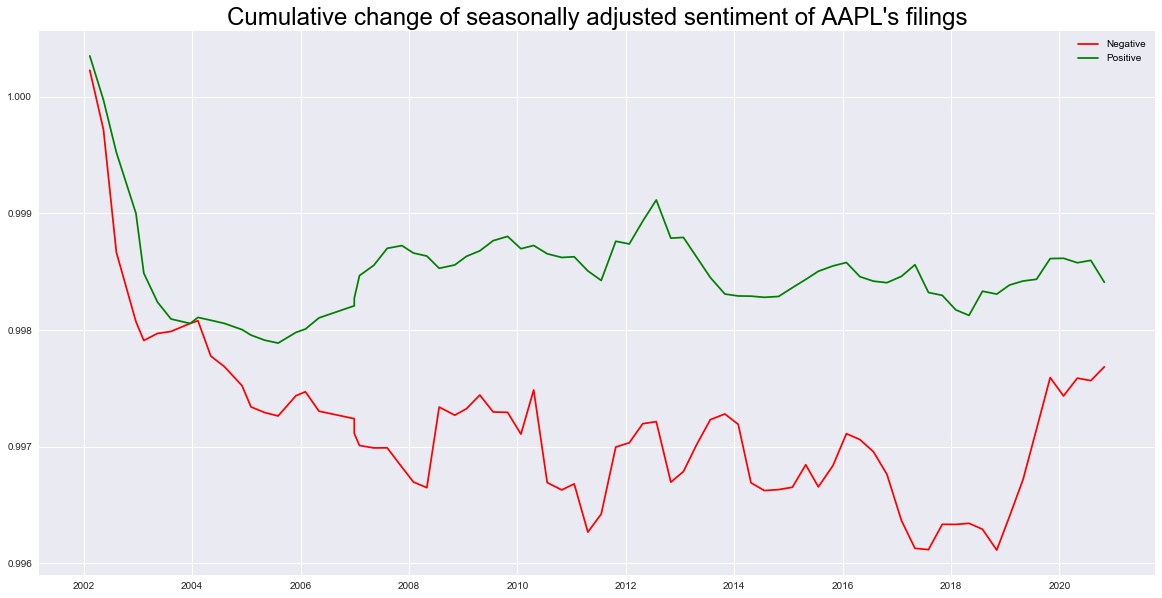

In [90]:
trial_df.index = pd.to_datetime(trial_df.index)
plt.plot(trial_df.index, (1+trial_df['Negative_standardised']).cumprod(), label = 'Negative', color = 'red')
plt.plot(trial_df.index, (1+trial_df['Positive_standardised']).cumprod(), label = 'Positive', color = 'green')
plt.title(f'Cumulative change of seasonally adjusted sentiment of {ticker.upper()}\'s filings', fontsize = 24)
plt.legend()
plt.show()

# Further data exploration with highlighted financial statements

In [398]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn
from collections import defaultdict
from nltk import pos_tag

lmcd_dictionary = pd.read_csv('LoughranMcDonald_MasterDictionary_2018.csv')
columns = ['Word', 'Negative', 'Positive', 'Uncertainty', 'Litigious', 'Constraining', 'Superfluous', 'Interesting']
lmcd_dictionary = lmcd_dictionary[columns]
lmcd_dictionary.dropna(subset = ['Word'], inplace = True, axis = 0)
lmcd_dictionary.reset_index(drop = True, inplace = True)
lmcd_dictionary.index = lmcd_dictionary.Word
lmcd_dictionary.drop('Word', inplace = True, axis = 1)
lmcd_dictionary[ lmcd_dictionary > 0 ] = 1

def lmcd_sentiment(df_idx):
    df_idx = df_idx.copy()
    text = df_idx.text.values[0] #' '.join( literal_eval( df_idx.lemmatised_text.values[0] ) )
    for i, word in enumerate(lmcd_dictionary.Word):
        if word in text.upper():
            df_idx[columns[1:]] += lmcd_dictionary.loc[i, columns[1:]].values
    return pd.DataFrame(df_idx)

def highlight_text( text, sentiment, color = '\033[43m', verbose = False, lmcd_dictionary = lmcd_dictionary):
        
    highlighted_text = ''
    end_color = '\033[m'
    
    tag_map = defaultdict( lambda : wn.NOUN )
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV

    for sentence in text.split('.'):
        sentiment_detected = False

        lemmatizer = WordNetLemmatizer()
        tokenized_words = word_tokenize(sentence.lower())

        for word, tag in pos_tag( tokenized_words ):
            if word not in stopwords and word.isalpha():
                lemmatised_word = lemmatizer.lemmatize(word, tag_map[tag[0]])
                if lemmatised_word.upper() in lmcd_dictionary.index:
                    if lmcd_dictionary.loc[lemmatised_word.upper()][sentiment] != 0:
                        if verbose:
                            print(word)
                        sentiment_detected = True

        if sentiment_detected:
            highlighted_text += color + ' ' + sentence + '.' + end_color 
        else:
            highlighted_text += ' ' + sentence + '.'
            
    return highlighted_text.replace('\n', '\n\n')


## Apple Highlighted Statement Example

In [399]:
color = '\033[31m'
sentiment = 'Negative'
ticker = 'aapl'
text = df[ df.ticker == ticker ].mdna.iloc[-1]
new_text = highlight_text(text, sentiment, color)
print('\x1b[1;11;11;11m Detected {} sentiment: \x1b[0m \n'.format(sentiment.lower()))
print(new_text[:2500])

 Item 7.     Management’s Discussion and Analysis of Financial Condition and Results of OperationsThe following discussion should be read in conjunction with the consolidated financial statements and accompanying notes included in Part II, Item 8 of this Form 10-K.  This section of this Form 10-K generally discusses 2020 and 2019 items and year-to-year comparisons between 2020 and 2019.  Discussions of 2018 items and year-to-year comparisons between 2019 and 2018 that are not included in this Form 10-K can be found in “Management’s Discussion and Analysis of Financial Condition and Results of Operations” in Part II, Item 7 of the Company’s Annual Report on Form 10-K for the fiscal year ended September 28, 2019. Fiscal Year HighlightsCOVID-19 UpdateCOVID-19 has spread rapidly throughout the world, prompting governments and businesses to take unprecedented measures in response.  Such measures have included restrictions on travel and business operations, temporary closures of businesses, 

In [401]:
sentiment = 'Positive'
start_color = '\033[42m'
end_color = '\033[m'
new_text = highlight_text(text, sentiment, color = start_color )
print('\x1b[1;11;11;11m Detected {} sentiment: \x1b[0m \n'.format(sentiment.lower()))
print(new_text[:2500])

 Item 7.     Management’s Discussion and Analysis of Financial Condition and Results of OperationsThe following discussion should be read in conjunction with the consolidated financial statements and accompanying notes included in Part II, Item 8 of this Form 10-K.  This section of this Form 10-K generally discusses 2020 and 2019 items and year-to-year comparisons between 2020 and 2019.  Discussions of 2018 items and year-to-year comparisons between 2019 and 2018 that are not included in this Form 10-K can be found in “Management’s Discussion and Analysis of Financial Condition and Results of Operations” in Part II, Item 7 of the Company’s Annual Report on Form 10-K for the fiscal year ended September 28, 2019. Fiscal Year HighlightsCOVID-19 UpdateCOVID-19 has spread rapidly throughout the world, prompting governments and businesses to take unprecedented measures in response.  Such measures have included restrictions on travel and business operations, temporary closures of businesses, 

## Coca-Cola Highlighted Statement Example

In [421]:
color = '\033[31m'
sentiment = 'Negative'
ticker = 'ko'
text = df[ df.ticker == ticker ].mdna.iloc[-1]
new_text = highlight_text(text, sentiment, color)
print('\x1b[1;11;11;11m Detected {} sentiment: \x1b[0m \n'.format(sentiment.lower()))
print(new_text[:2500])

 Detected negative sentiment  

 Item 2.   Management's Discussion and Analysis of Financial Condition and Results of OperationsWhen used in this report, the terms "The Coca-Cola Company," "Company," "we," "us" and "our" mean The Coca-Cola Company and all entities included in our condensed consolidated financial statements. During the nine months ended September 25, 2020, the effects of a novel strain of coronavirus ("COVID-19") pandemic and the related actions by governments around the world to attempt to contain the spread of the virus have impacted our business globally.  In particular, the outbreak and preventive measures taken to contain COVID-19 negatively impacted our unit case volume and our price, product and geographic mix in all of our operating segments, primarily due to unfavorable channel and product mix as consumer demand has shifted to more at-home consumption versus away from home.  In response to the COVID-19 outbreak and business disruption, we have five priorities:•

In [422]:
color = '\033[32m'
sentiment = 'Positive'
ticker = 'ko'
text = df[ df.ticker == ticker ].mdna.iloc[-1]
new_text = highlight_text(text, sentiment, color)
print('\x1b[1;11;11;11m Detected {} sentiment: \x1b[0m \n'.format(sentiment.lower()))
print(new_text[:2500])

 Detected positive sentiment:  

 Item 2.   Management's Discussion and Analysis of Financial Condition and Results of OperationsWhen used in this report, the terms "The Coca-Cola Company," "Company," "we," "us" and "our" mean The Coca-Cola Company and all entities included in our condensed consolidated financial statements. During the nine months ended September 25, 2020, the effects of a novel strain of coronavirus ("COVID-19") pandemic and the related actions by governments around the world to attempt to contain the spread of the virus have impacted our business globally.  In particular, the outbreak and preventive measures taken to contain COVID-19 negatively impacted our unit case volume and our price, product and geographic mix in all of our operating segments, primarily due to unfavorable channel and product mix as consumer demand has shifted to more at-home consumption versus away from home.  In response to the COVID-19 outbreak and business disruption, we have five priorities:

## Similarity Metrics

### Cosine Similarity Example of Apple

,1994-12-13,1995-12-19,1996-08-12,1996-12-19,1997-02-10,1997-12-05,1998-02-09,1998-05-11,1998-08-10,1999-12-22,...,2018-08-01,2018-11-05,2019-01-30,2019-05-01,2019-07-31,2019-10-31,2020-01-29,2020-05-01,2020-07-31,2020-10-30
1994-12-13,1.000000,0.955364,0.896542,0.894352,0.883624,0.853819,0.851326,0.767472,0.777809,0.826634,...,0.606213,0.666649,0.655636,0.632370,0.627290,0.627068,0.594926,0.564637,0.579278,0.622284
1995-12-19,0.955364,1.000000,0.929616,0.928711,0.906614,0.887112,0.891272,0.762972,0.779049,0.845705,...,0.607263,0.665130,0.664011,0.632763,0.628729,0.622288,0.590502,0.561434,0.573931,0.616944
1996-08-12,0.896542,0.929616,1.000000,0.980226,0.960829,0.934357,0.937235,0.794221,0.811560,0.867965,...,0.629758,0.687078,0.695234,0.656100,0.650411,0.643978,0.609492,0.579768,0.588898,0.640007
1996-12-19,0.894352,0.928711,0.980226,1.000000,0.964539,0.933118,0.935352,0.802123,0.817415,0.873979,...,0.644474,0.699276,0.702099,0.665480,0.659703,0.651287,0.616338,0.586016,0.594580,0.644428
1997-02-10,0.883624,0.906614,0.960829,0.964539,1.000000,0.947991,0.943219,0.821176,0.827644,0.861738,...,0.625592,0.682476,0.676380,0.641560,0.634715,0.631104,0.591900,0.565308,0.571488,0.625389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-31,0.627068,0.622288,0.643978,0.651287,0.631104,0.648711,0.630094,0.661514,0.662539,0.674274,...,0.859792,0.921514,0.923064,0.937411,0.938374,1.000000,0.906468,0.839803,0.871679,0.952091
2020-01-29,0.594926,0.590502,0.609492,0.616338,0.591900,0.614962,0.587511,0.616463,0.616147,0.638282,...,0.810203,0.820243,0.917059,0.930108,0.943791,0.906468,1.000000,0.890626,0.919232,0.898325
2020-05-01,0.564637,0.561434,0.579768,0.586016,0.565308,0.587918,0.560682,0.595189,0.592570,0.598217,...,0.752346,0.771219,0.841165,0.864013,0.872964,0.839803,0.890626,1.000000,0.925723,0.889251
2020-07-31,0.579278,0.573931,0.588898,0.594580,0.571488,0.594208,0.564178,0.603847,0.602744,0.605873,...,0.762628,0.800030,0.868152,0.892049,0.902425,0.871679,0.919232,0.925723,1.000000,0.903997


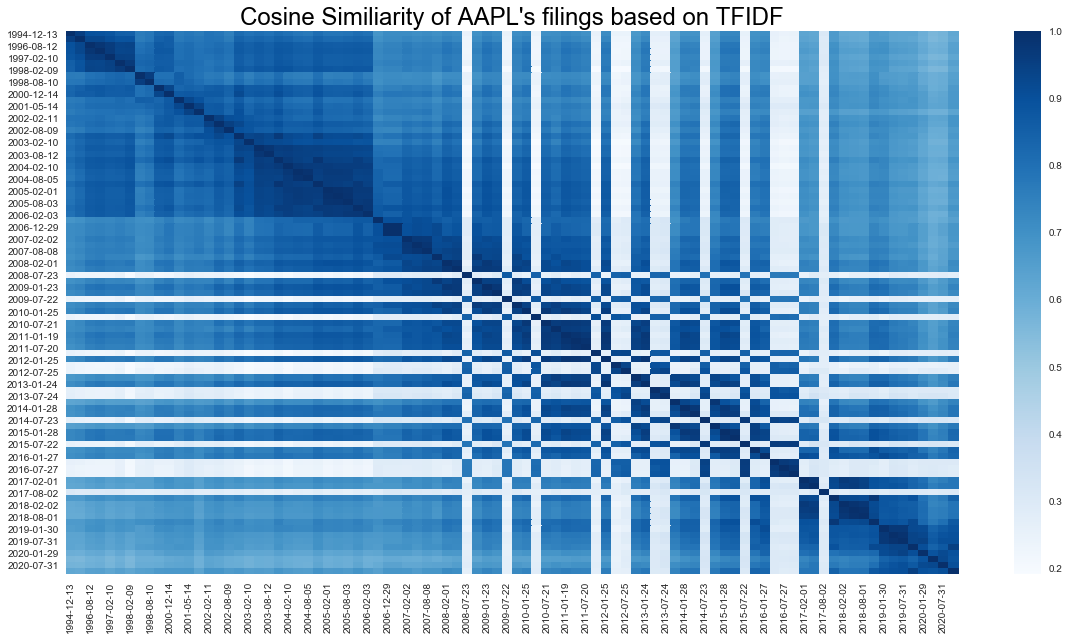

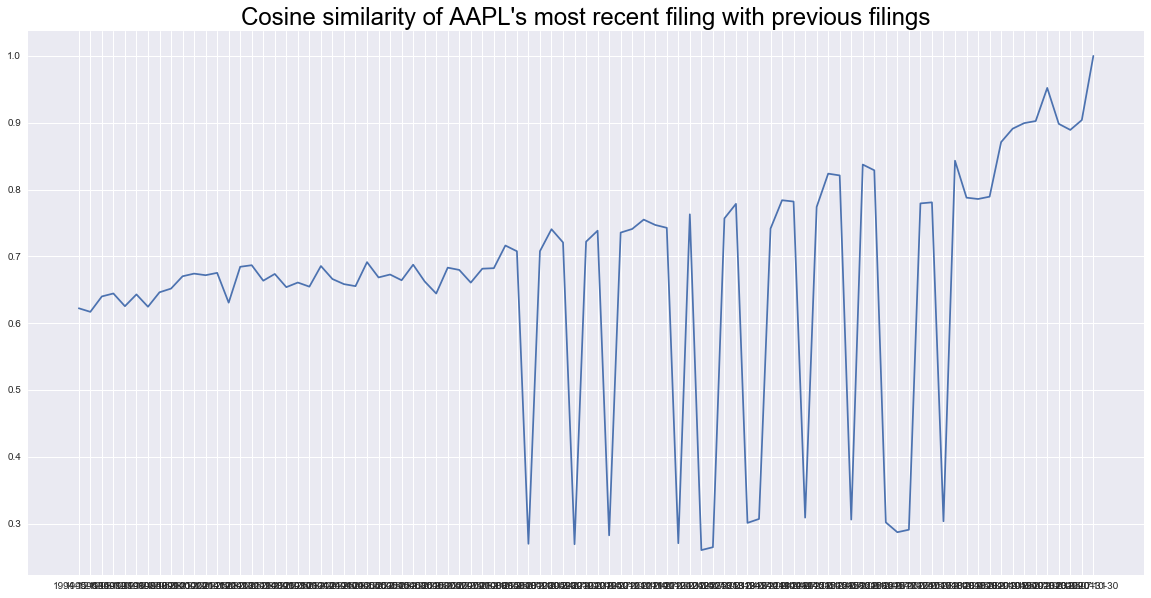

In [94]:
ticker = 'aapl'
trial_df = df[df.ticker == ticker].copy()

# cosine similarity with tfidf or word2vec
tfidf = TfidfVectorizer()
tfidf_df = tfidf.fit_transform(trial_df.text).toarray()
rows = []
for j in range(len(tfidf_df)):
    columns = []
    for i in range(len(tfidf_df)):
        columns.append( cosine_similarity(tfidf_df[j].reshape(1, -1), tfidf_df[i].reshape(1, -1))[0][0] )
    rows.append(columns)
    
cosine_similiarity = pd.DataFrame(rows, columns = trial_df.index, index = trial_df.index )
display(cosine_similiarity)

# similiarity heatmap plot
sns.heatmap(cosine_similiarity, cmap = 'Blues')
plt.title(f'Cosine Similiarity of {ticker.upper()}\'s filings based on TFIDF', fontsize = 24 )
plt.show()

# plot of similiarity of previous reports to most recent report
plt.plot(cosine_similiarity.iloc[:,-1])
plt.title(f'Cosine similarity of {ticker.upper()}\'s most recent filing with previous filings', fontsize = 24 )
plt.show()

### Cosine Similarity Example of Procter & Gamble

,1995-09-13,1997-09-10,1998-09-09,1999-09-15,2000-09-13,2001-09-12,2002-09-12,2003-09-11,2004-04-30,2004-09-09,...,2018-08-07,2018-10-19,2019-01-23,2019-04-23,2019-08-06,2019-10-22,2020-01-23,2020-04-20,2020-08-06,2020-10-20
1995-09-13,1.000000,0.295244,0.275393,0.214726,0.314194,0.220670,0.268744,0.246103,0.060489,0.253017,...,0.074151,0.066916,0.048929,0.053318,0.088831,0.063807,0.048426,0.047008,0.081586,0.063105
1997-09-10,0.295244,1.000000,0.775371,0.422471,0.640830,0.493079,0.594949,0.529895,0.204021,0.489064,...,0.237524,0.203387,0.176103,0.174768,0.255776,0.190345,0.162968,0.163251,0.255476,0.188562
1998-09-09,0.275393,0.775371,1.000000,0.513279,0.662677,0.585156,0.648286,0.526244,0.219008,0.482280,...,0.237978,0.219061,0.193890,0.190826,0.253770,0.214544,0.188594,0.185759,0.260951,0.208156
1999-09-15,0.214726,0.422471,0.513279,1.000000,0.531962,0.430965,0.495231,0.445946,0.247527,0.408206,...,0.255522,0.227475,0.192551,0.189728,0.277132,0.216615,0.182916,0.183495,0.282777,0.216764
2000-09-13,0.314194,0.640830,0.662677,0.531962,1.000000,0.743092,0.855027,0.711580,0.268091,0.653361,...,0.299769,0.282883,0.238844,0.235767,0.326969,0.271000,0.224906,0.221868,0.331471,0.256051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-22,0.063807,0.190345,0.214544,0.216615,0.271000,0.213474,0.292190,0.288299,0.637784,0.312135,...,0.869723,0.942810,0.935652,0.936765,0.825446,1.000000,0.977517,0.931666,0.839298,0.940208
2020-01-23,0.048426,0.162968,0.188594,0.182916,0.224906,0.177078,0.244751,0.236007,0.619343,0.264011,...,0.848395,0.904951,0.926699,0.929123,0.783856,0.977517,1.000000,0.950091,0.812514,0.932839
2020-04-20,0.047008,0.163251,0.185759,0.183495,0.221868,0.175364,0.245355,0.237950,0.595457,0.265197,...,0.826814,0.874981,0.892066,0.896226,0.763550,0.931666,0.950091,1.000000,0.855464,0.963982
2020-08-06,0.081586,0.255476,0.260951,0.282777,0.331471,0.269633,0.354726,0.351243,0.593391,0.361164,...,0.895952,0.821781,0.806535,0.814256,0.915626,0.839298,0.812514,0.855464,1.000000,0.867515


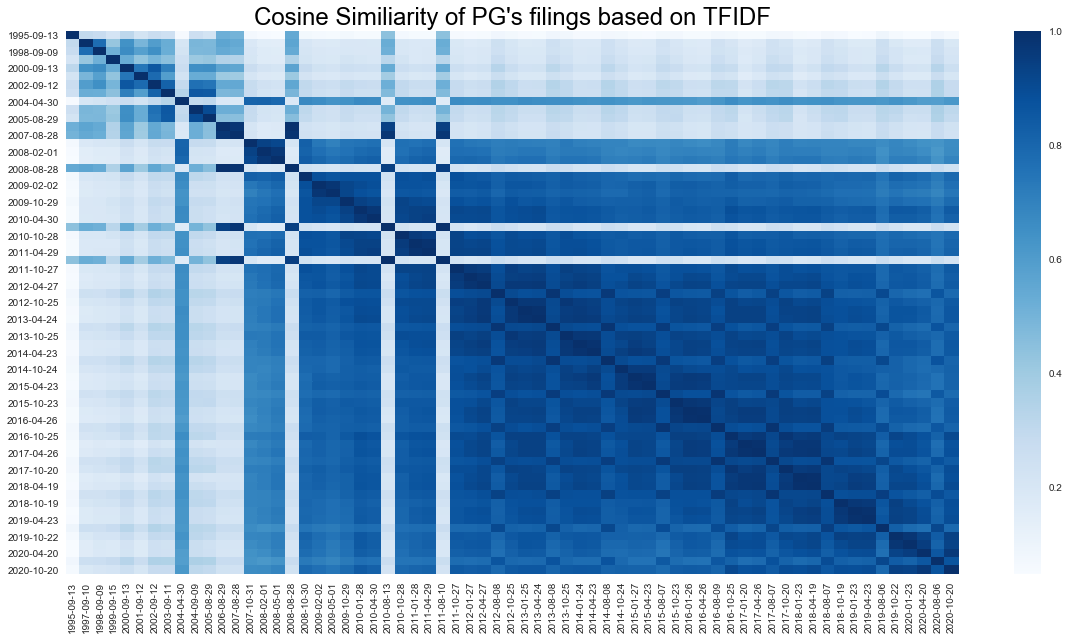

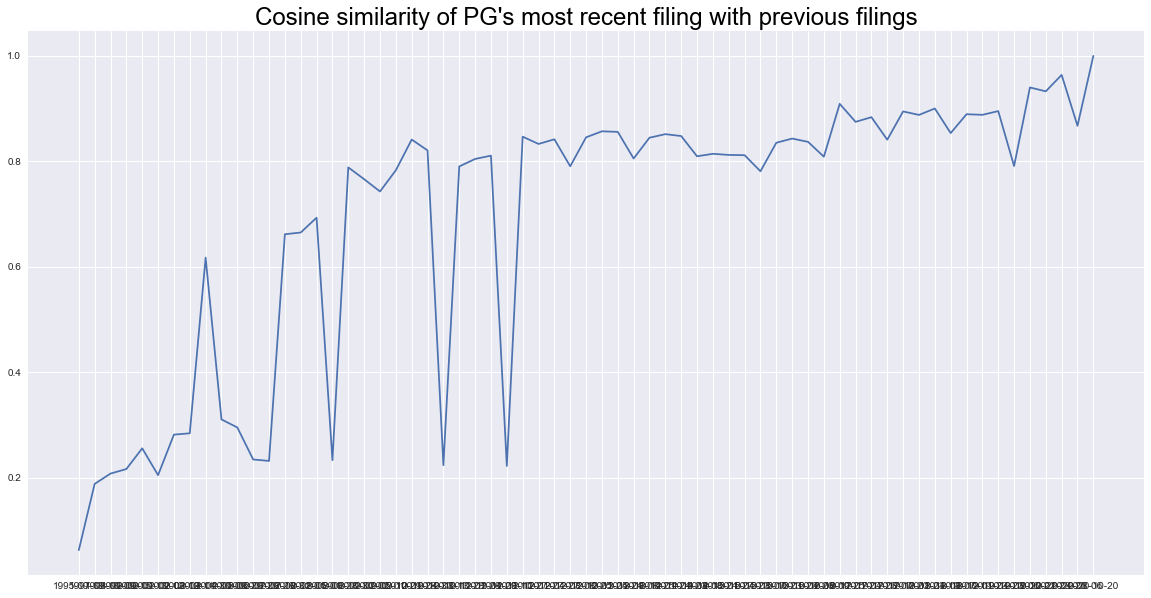

In [95]:
ticker = 'pg'
trial_df = df[df.ticker == ticker].copy()

# cosine similarity with tfidf or word2vec
tfidf = TfidfVectorizer()
tfidf_df = tfidf.fit_transform(trial_df.text).toarray()
rows = []
for j in range(len(tfidf_df)):
    columns = []
    for i in range(len(tfidf_df)):
        columns.append( cosine_similarity(tfidf_df[j].reshape(1, -1), tfidf_df[i].reshape(1, -1))[0][0] )
    rows.append(columns)
    
cosine_similiarity = pd.DataFrame(rows, columns = trial_df.index, index = trial_df.index )
display(cosine_similiarity)

# similiarity heatmap plot
sns.heatmap(cosine_similiarity, cmap = 'Blues')
plt.title(f'Cosine Similiarity of {ticker.upper()}\'s filings based on TFIDF', fontsize = 24 )
plt.show()

# plot of similiarity of previous reports to most recent report
plt.plot(cosine_similiarity.iloc[:,-1])
plt.title(f'Cosine similarity of {ticker.upper()}\'s most recent filing with previous filings', fontsize = 24 )
plt.show()

## Containment scores

In [82]:
# containment function
def calculate_containment(df1, df2, ngram_size):
    text1 = df1.text
    text2 = df2.text
    counts = CountVectorizer(analyzer='word', ngram_range=(ngram_size, ngram_size))
    ngrams = counts.fit_transform([text1, text2])
    
    ngram_array = ngrams.toarray()
    intersect = np.amin(ngram_array, axis=0)
    common_ngrams = sum(intersect)
    
    len_ngram_a = sum(ngram_array[0])
    
    containment_score = 1.0 * common_ngrams / len_ngram_a
    
    return containment_score

,1994-12-13,1995-12-19,1996-08-12,1996-12-19,1997-02-10,1997-12-05,1998-02-09,1998-05-11,1998-08-10,1999-12-22,...,2018-08-01,2018-11-05,2019-01-30,2019-05-01,2019-07-31,2019-10-31,2020-01-29,2020-05-01,2020-07-31,2020-10-30
1994-12-13,1.000000,0.620942,0.365408,0.346910,0.319596,0.209665,0.257150,0.252971,0.226471,0.168387,...,0.081743,0.076128,0.101310,0.094865,0.100448,0.090571,0.106749,0.103966,0.103020,0.098537
1995-12-19,0.753814,1.000000,0.487410,0.479351,0.416597,0.278895,0.331303,0.285229,0.253676,0.202217,...,0.081107,0.076400,0.104803,0.096171,0.102242,0.090107,0.104683,0.101822,0.098706,0.099024
1996-08-12,0.516525,0.567539,1.000000,0.736827,0.668349,0.424655,0.497881,0.384550,0.323529,0.256307,...,0.095102,0.090538,0.110917,0.107920,0.110314,0.101254,0.112948,0.117899,0.108954,0.109756
1996-12-19,0.516102,0.587435,0.775480,1.000000,0.727782,0.480868,0.531250,0.426995,0.369853,0.268349,...,0.097328,0.092713,0.106114,0.104003,0.107623,0.100325,0.103994,0.111468,0.107875,0.110244
1997-02-10,0.483051,0.518674,0.714628,0.739390,1.000000,0.500000,0.580244,0.480475,0.406618,0.273700,...,0.098601,0.095976,0.110917,0.112707,0.114798,0.108686,0.112948,0.120579,0.108954,0.113659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-31,0.082627,0.067714,0.065348,0.061521,0.065601,0.062919,0.065678,0.134975,0.120588,0.069190,...,0.396310,0.455139,0.610044,0.644909,0.664574,1.000000,0.749311,0.618435,0.602481,0.778049
2020-01-29,0.065678,0.053054,0.049161,0.043008,0.045977,0.042209,0.046081,0.094228,0.082353,0.056384,...,0.335242,0.268896,0.544978,0.554395,0.579821,0.505341,1.000000,0.697213,0.672600,0.481951
2020-05-01,0.082203,0.066318,0.065947,0.059242,0.063078,0.058974,0.060646,0.122241,0.108088,0.066514,...,0.355598,0.291191,0.536245,0.590949,0.608072,0.535996,0.896006,1.000000,0.840885,0.573171
2020-07-31,0.080932,0.063874,0.060552,0.056964,0.056630,0.055424,0.056939,0.116299,0.106618,0.064411,...,0.347010,0.293366,0.514410,0.556571,0.575336,0.518811,0.858815,0.835477,1.000000,0.610244


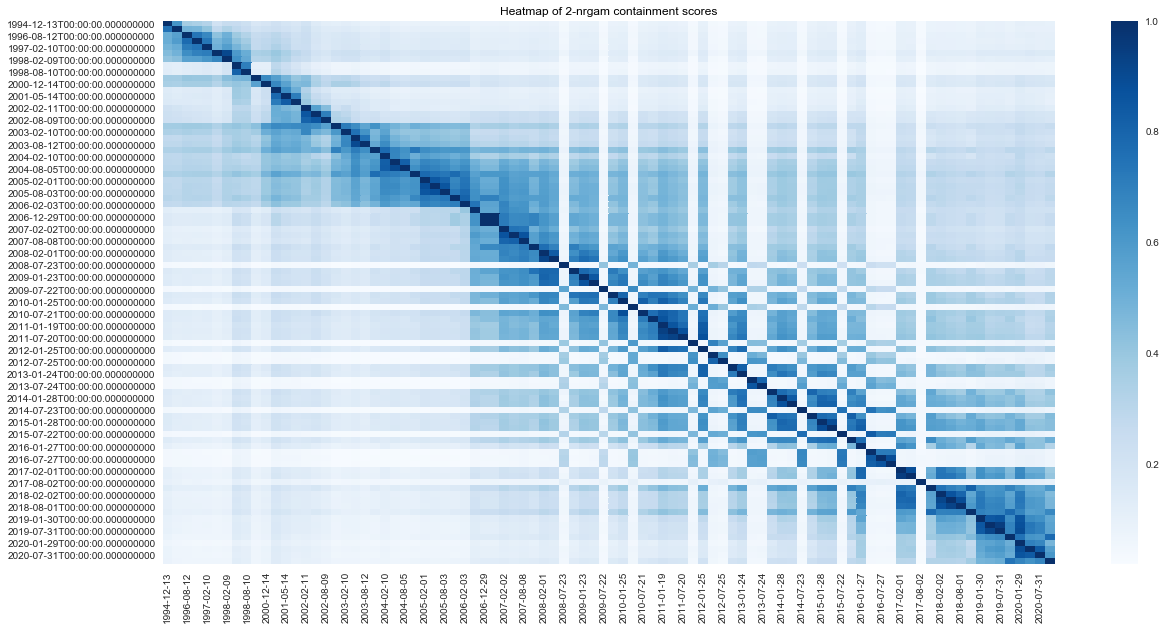

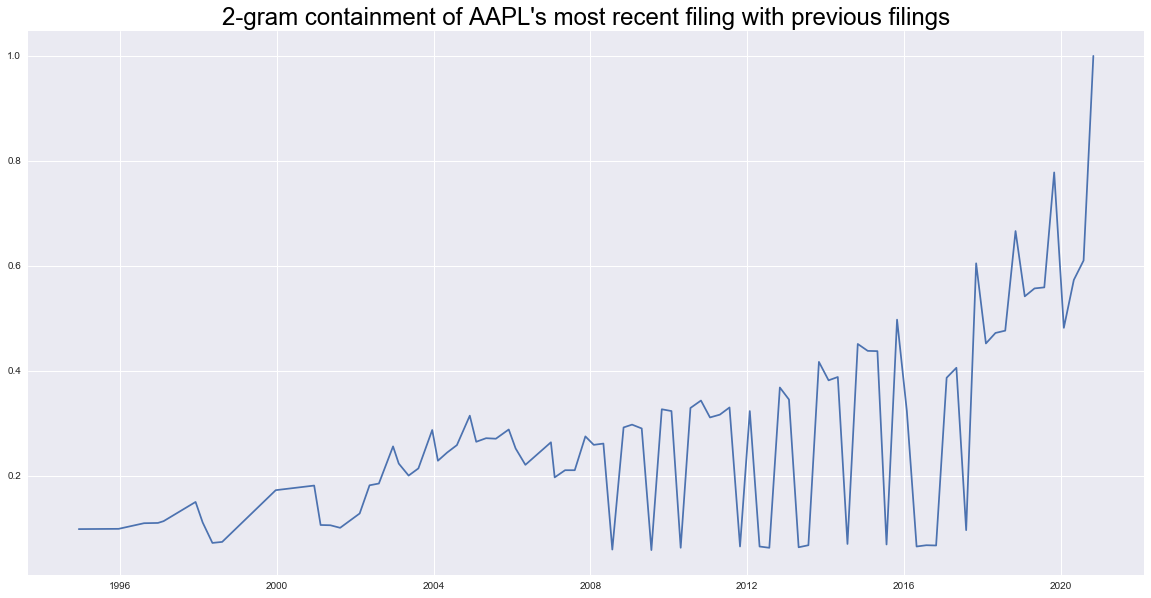

In [92]:
ticker = 'aapl'
trial_df = df[df.ticker == ticker].copy()

# 2-ngram containment
ngram = 2
rows = []
for j in range(len(trial_df)):
    columns = []
    for i in range(len(trial_df)):
        columns.append( calculate_containment( trial_df.iloc[i], trial_df.iloc[j], ngram ) )
    rows.append(columns)
containment_df = pd.DataFrame(rows, index = pd.to_datetime(trial_df.index), columns = trial_df.index )

# containment df
display(containment_df)

# containment heatmap
plt.title('Heatmap of 2-nrgam containment scores')
sns.heatmap(containment_df, cmap = 'Blues')
plt.show()


# plot of containment of previous reports to most recent report
plt.plot(containment_df.iloc[:,-1])
plt.title(f"2-gram containment of {ticker.upper()}'s most recent filing with previous filings", fontsize = 24 )
plt.show()

,1995-09-13,1997-09-10,1998-09-09,1999-09-15,2000-09-13,2001-09-12,2002-09-12,2003-09-11,2004-04-30,2004-09-09,...,2018-08-07,2018-10-19,2019-01-23,2019-04-23,2019-08-06,2019-10-22,2020-01-23,2020-04-20,2020-08-06,2020-10-20
1995-09-13,1.00,0.131387,0.127660,0.042821,0.109677,0.086735,0.076923,0.077273,0.004095,0.101010,...,0.000831,0.001948,0.001269,0.001206,0.001065,0.001909,0.001307,0.000995,0.000960,0.001761
1997-09-10,0.72,1.000000,0.730496,0.236776,0.451613,0.352041,0.362637,0.286364,0.012739,0.237374,...,0.003085,0.005566,0.003807,0.003446,0.003596,0.005183,0.003735,0.003317,0.003601,0.005284
1998-09-09,0.72,0.751825,1.000000,0.292191,0.496774,0.387755,0.395604,0.290909,0.013649,0.247475,...,0.002492,0.005288,0.003626,0.003274,0.003063,0.005183,0.003548,0.003317,0.003241,0.004529
1999-09-15,0.68,0.686131,0.822695,1.000000,0.567742,0.438776,0.461538,0.327273,0.021838,0.282828,...,0.005696,0.011411,0.007614,0.007065,0.007591,0.010911,0.007656,0.007132,0.007201,0.009562
2000-09-13,0.68,0.510949,0.546099,0.221662,1.000000,0.734694,0.686813,0.454545,0.025023,0.388889,...,0.004391,0.011133,0.007433,0.006893,0.004927,0.010911,0.007656,0.006635,0.006001,0.009814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-22,0.28,0.138686,0.134752,0.100756,0.258065,0.214286,0.247253,0.268182,0.238399,0.262626,...,0.280646,0.772057,0.556744,0.544029,0.324810,1.000000,0.633987,0.548516,0.333773,0.695773
2020-01-23,0.28,0.145985,0.134752,0.103275,0.264516,0.219388,0.247253,0.268182,0.270701,0.262626,...,0.344013,0.787364,0.696519,0.686024,0.359169,0.926077,1.000000,0.779897,0.386342,0.764721
2020-04-20,0.24,0.145985,0.141844,0.108312,0.258065,0.214286,0.241758,0.272727,0.281620,0.267677,...,0.349591,0.778736,0.687455,0.674306,0.364096,0.902073,0.878058,1.000000,0.441791,0.853548
2020-08-06,0.32,0.218978,0.191489,0.151134,0.322581,0.265306,0.307692,0.336364,0.268426,0.328283,...,0.628337,0.698302,0.547679,0.534034,0.775469,0.758592,0.601120,0.610549,1.000000,0.761449


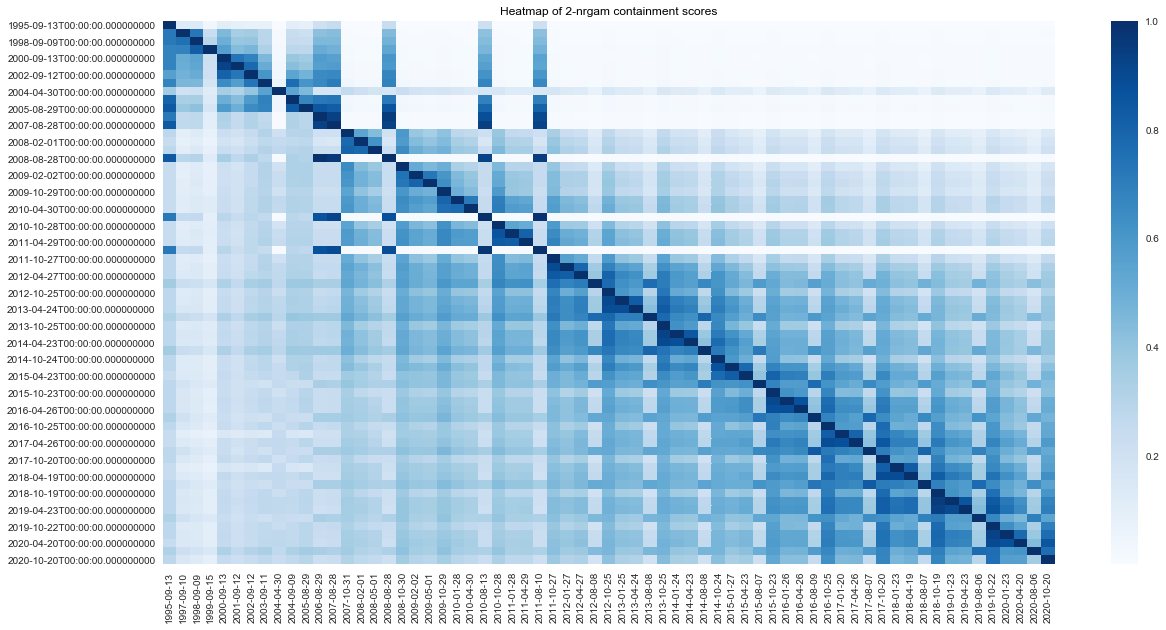

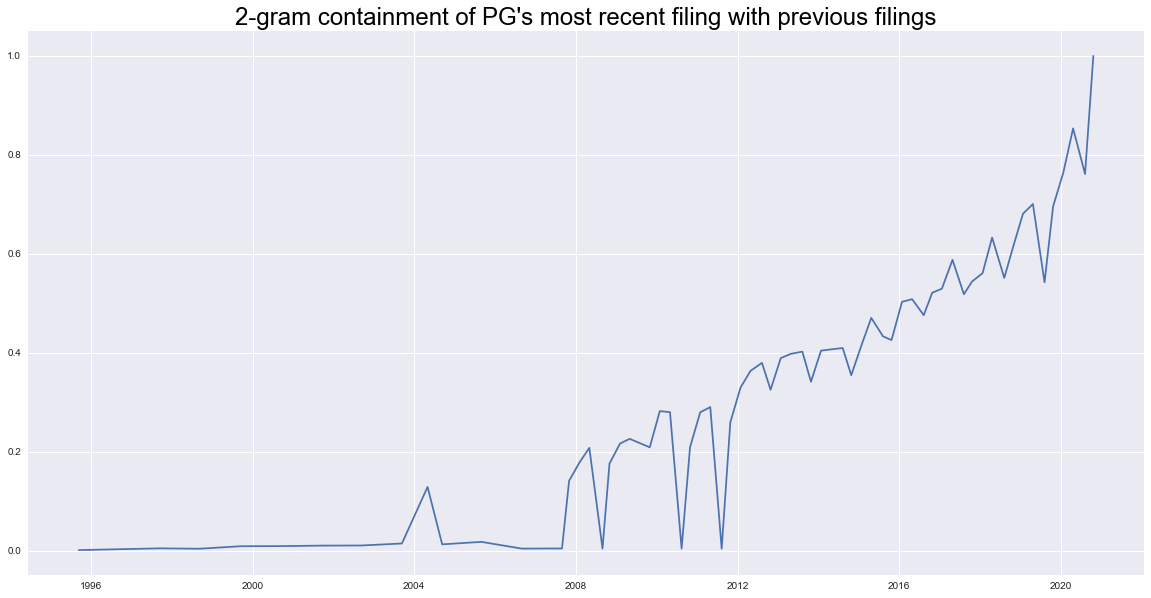

In [93]:
ticker = 'pg'
trial_df = df[df.ticker == ticker].copy()

# 2-ngram containment
ngram = 2
rows = []
for j in range(len(trial_df)):
    columns = []
    for i in range(len(trial_df)):
        columns.append( calculate_containment( trial_df.iloc[i], trial_df.iloc[j], ngram ) )
    rows.append(columns)
containment_df = pd.DataFrame(rows, index = pd.to_datetime(trial_df.index), columns = trial_df.index )

# containment df
display(containment_df)

# containment heatmap
plt.title('Heatmap of 2-nrgam containment scores')
sns.heatmap(containment_df, cmap = 'Blues')
plt.show()


# plot of containment of previous reports to most recent report
plt.plot(containment_df.iloc[:,-1])
plt.title(f"2-gram containment of {ticker.upper()}'s most recent filing with previous filings", fontsize = 24 )
plt.show()